In [53]:
# BASE ENV

import math
import numpy as np
import itertools
from tqdm.notebook import tqdm


class CarStates:
    empty = 0
    with_passanger = 1
    total = 2


class TaxiMDP:
    def __init__(self, square_size=5, passegner=(0, 0), car=(4, 1), target=(3, 4)):
        self.square_size = square_size
        self.passenger_start_position = passegner
        self.car_start_position = car
        self.target = target
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        self.car_state = CarStates.empty
        self.reset()

    def reset(self):
        self.car = self.car_start_position
        self.passenger = self.passenger_start_position
        self.car_state = CarStates.empty
        return self.encode_state_to_index(self.get_state()), None

    def _is_out_of_field(self, row, col):
        if row < 0 or row > self.square_size - 1:
            return True
        if col < 0 or col > self.square_size - 1:
            return True
        return False

    def get_action_mask(self, state):
        mask = np.ones((len(self.actions)), dtype=int)
        for i, a in enumerate(self.actions):
            if self._is_out_of_field(state[0] + a[0], state[1] + a[1]):
                mask[i] = 0
        return mask

    def reward(self, state):
        reward = -1
        row, col, car_state = state
        if car_state == CarStates.empty and (row, col) == tuple(self.passenger):
            reward = 10
        elif car_state == CarStates.with_passanger and (row, col) == tuple(self.target):
            reward = 10
        return reward

    def next_state(self, state, a: int):
        a_dir = self.actions[a]
        row, col, car_state = state
        if (
            car_state == CarStates.empty
            and row == self.passenger[0]
            and col == self.passenger[1]
        ):
            self.car_state = CarStates.with_passanger
            return self.get_state()

        mask = self.get_action_mask(state)
        if mask[a] > 0:
            return (row + a_dir[0], col + a_dir[1], car_state)
        else:
            return state

    def get_state(self):
        return self.car[0], self.car[1], self.car_state

    def step(self, a: int):
        new_sate = self.next_state(self.get_state(), a)
        r = self.reward(new_sate)
        row, col, _ = new_sate
        self.car = np.array([row, col])
        if self.car_state == CarStates.with_passanger:
            self.passenger = np.array([row, col])
        terminated = False
        if tuple(self.passenger) == tuple(self.target):
            terminated = True
        return self.encode_state_to_index(new_sate), r, terminated

    def get_default_policy(self):
        policy = np.zeros(
            (self.square_size, self.square_size, CarStates.total, len(self.actions)),
            dtype=float,
        )
        for row, col, car_state in itertools.product(
            range(self.square_size), range(self.square_size), range(CarStates.total)
        ):
            a_mask = self.get_action_mask((row, col, car_state))
            policy[row, col, car_state] = a_mask / a_mask.sum()
        return policy

    def sample_with_policy(self, policy, random_action=False):
        prob = policy[self.car[0], self.car[1], self.car_state]
        if random_action:
            a = np.random.default_rng().choice(len(self.actions), p=prob)
        else:
            a = np.argmax(prob)
        return self.step(a)

    def get_total_states(self):
        return self.square_size**2 * CarStates.total

    def decode_state_from_index(self, index: int):
        car_state = CarStates.empty
        if index >= self.square_size**2:
            car_state = CarStates.with_passanger
            index -= self.square_size**2

        row = index // self.square_size
        col = index % self.square_size
        return (row, col, car_state)

    def encode_state_to_index(self, state):
        index = 0
        index += state[0] * self.square_size
        index += state[1]
        index += self.square_size**2 * state[2]
        return index

In [54]:
# функции с семинаров
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label="Mean return")
    plt.legend(loc=4)
    plt.grid()
    plt.show()


def compare_logs(logs, title):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    plt.title(title)
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f"{method_name}")
        plt.legend()
    plt.grid()
    plt.show()


class Model:
    def __init__(self, n_states, n_actions, seed):
        self.mask_state = np.zeros([n_states], dtype=int)
        self.mask_state_action = np.zeros([n_states, n_actions], dtype=int)
        self.r = np.zeros_like(self.mask_state_action, dtype=float)
        self.next_s = np.zeros_like(self.mask_state_action, dtype=int)
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        self.mask_state[s] = 1
        self.mask_state_action[s][a] = 1
        self.r[s][a] = r
        self.next_s[s][a] = next_s
        return r

    def sample(self) -> tuple[int, int, float, int]:
        """
        returns s, a, r, next_s
        """
        s = self._rng.choice(np.where(self.mask_state > 0)[0])
        a = self._rng.choice(np.where(self.mask_state_action[s] > 0)[0])
        return s, a, self.r[s][a], self.next_s[s][a]


class DynaQAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)

    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        # Обновите модель, если нужно, реализуйте шаг Q-обучения
        if update_model:
            r = self.model.add(s, a, r, s_n)

        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        Q_s_a = self.Q[s, a]
        V_sn = np.max(self.Q[s_n])

        td_error = r + self.gamma * V_sn - Q_s_a
        self.Q[s, a] += self.lr * td_error

    def dream(self, max_steps, **_):
        for _ in range(max_steps):
            # Добавьте шаг обучения с использованием модели
            m_s, m_a, m_r, m_next_s = self.model.sample()
            self.update(m_s, m_a, m_r, m_next_s, update_model=False)


def train(
    env,
    agent,
    n_episodes,
    on_model_updates,
    show_progress_flag=True,
    show_progress_schedule=50,
):
    avg_returns, returns_batch, elapsed_time_history = [], [], []
    # rng = np.random.default_rng(seed)
    start_time = time.time()
    for i in range(1, n_episodes):
        state, _ = env.reset()
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated = env.step(action)
            agent.update(state, action, reward, next_state, update_model=True)
            state = next_state
            episode_return += reward
            done = terminated
            if done:
                break
            agent.dream(on_model_updates, state=state)

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            end_time = time.time()
            elapsed_time = end_time - start_time
            elapsed_time_history.append((i, elapsed_time))
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []

            if show_progress_flag:
                show_progress(avg_returns)
                print(
                    f"Episode: {i}, Return: {episode_return}, "
                    f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}, "
                    f"Elapsed time: {elapsed_time:.2f} seconds"
                )
            start_time = time.time()

    return avg_returns, elapsed_time_history

### Сетап среды (всегда будем учится на одних координатах чтобы сравнивать было честно)


In [55]:
import random

random.seed(42)

square_size = 5

positions = [
    (x, y) for x, y in itertools.product(range(square_size), range(square_size))
]

random_positions = random.sample(positions, 3)  # сэмплируем координаты

env = TaxiMDP(
    square_size=square_size,
    passegner=random_positions[0],
    car=random_positions[1],
    target=random_positions[2],
)
random_positions

[(4, 0), (0, 3), (0, 0)]

### Детерминированная среда:


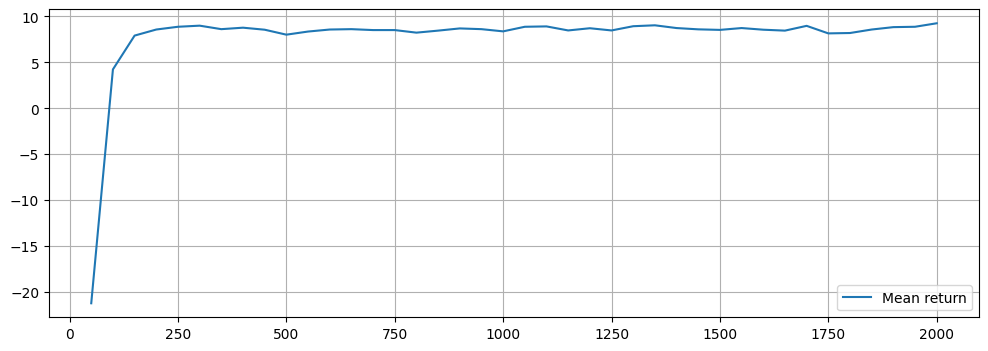

Episode: 2000, Return: 10, AvgReturn[50]: 9, Elapsed time: 0.02 seconds


In [56]:
# пример как считает DynaQ (тут формально обычно Q-обучение)

seed = 1337
agent = DynaQAgent(
    n_states=env.get_total_states(),
    n_actions=4,
    lr=0.05,
    gamma=0.975,
    eps=0.1,
    seed=seed,
    f_model=Model,
)

log_q, log_time = train(
    env,
    agent,
    n_episodes=2001,
    on_model_updates=0,
    show_progress_schedule=50,
)

In [57]:
on_model_updates_dict = {i: dict() for i in range(11)}
for key in tqdm(on_model_updates_dict.keys()):
    seed = 1337
    agent = DynaQAgent(
        n_states=env.get_total_states(),
        n_actions=4,
        lr=0.05,
        gamma=0.975,
        eps=0.1,
        seed=seed,
        f_model=Model,
    )

    log_q, log_time = train(
        env,
        agent,
        n_episodes=2001,
        on_model_updates=key,
        show_progress_flag=False,
        show_progress_schedule=25,
    )
    on_model_updates_dict[key]["log_q"] = log_q
    on_model_updates_dict[key]["log_time"] = log_time

  0%|          | 0/11 [00:00<?, ?it/s]

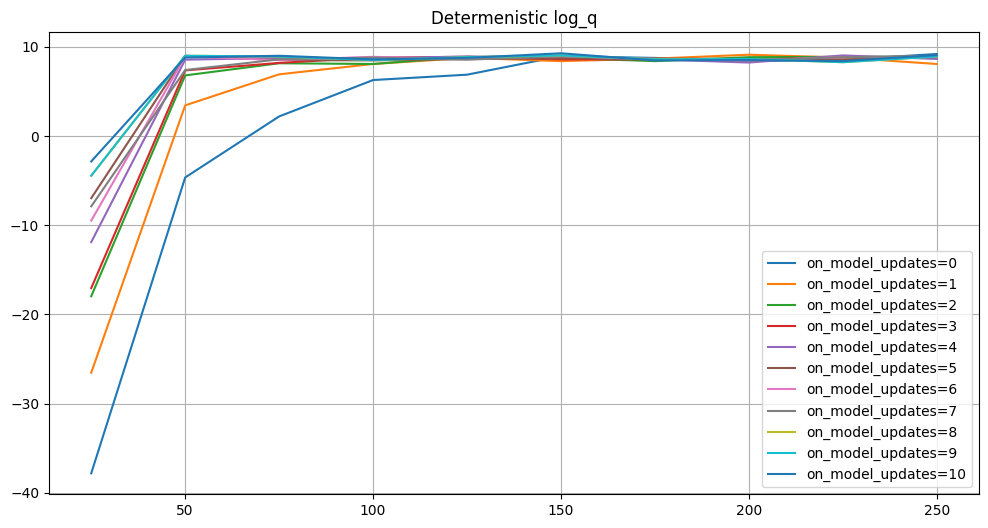

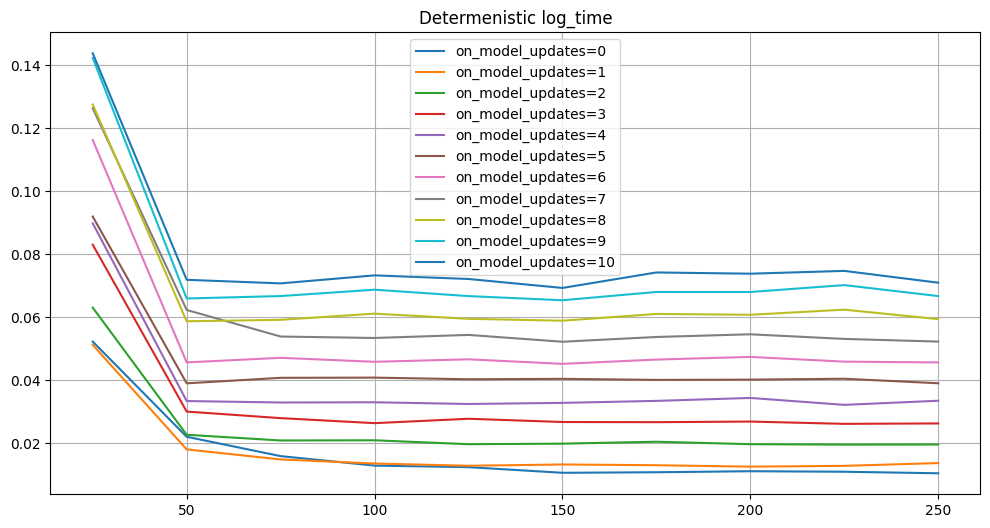

In [58]:
# графики для детерменированной среды

logs = []
for key in on_model_updates_dict.keys():
    logs.append(
        (on_model_updates_dict[key]["log_q"][:10], f"on_model_updates={key}")
    )  # ограничл число итераций тк после 250 впринципе достигнут оптимум


compare_logs(logs, title="Determenistic log_q")

logs = []
for key in on_model_updates_dict.keys():
    logs.append(
        (on_model_updates_dict[key]["log_time"][:10], f"on_model_updates={key}")
    )  # ограничл число итераций тк после 250 впринципе достигнут оптимум


compare_logs(logs, title="Determenistic log_time")

#### Выводы 

В целом получаем достаточно очевидный результат, что увеличение "мечтания" Dyna приводит к тому, что модель сходится к оптимуму за меньшее число итераций (темная синяя линия с 10 шагами на помечтать с первых 25 итераций почти вышла в 0), но при этом на сам отрезок итераций уходит больше секунд (что логично, тк мы больше сэмплируем, в на 25 итераций требуется в 4 раза больше времени при величине мечтания = 10 по сравнению с мечтанием = 10)

### Стохастическая среда


In [59]:
class StohTaxiMDP(TaxiMDP):
    def __init__(
        self,
        square_size=5,
        passegner=(0, 0),
        car=(4, 1),
        target=(3, 4),
        p_error=0.1,
    ):
        self.p_error = p_error
        super().__init__(square_size, passegner, car, target)

    def next_state(self, state, a: int):
        a_dir = self.actions[a]
        row, col, car_state = state
        if (
            car_state == CarStates.empty
            and row == self.passenger[0]
            and col == self.passenger[1]
        ):
            self.car_state = CarStates.with_passanger
            return self.get_state()

        mask = self.get_action_mask(state)
        if mask[a] > 0:
            # Введем вероятность ошибки
            if np.random.rand() < self.p_error:
                # Случайный переход в соседнее состояние
                a_new = np.random.choice(np.where(mask > 0)[0])
                a_dir = self.actions[a_new]
            return (row + a_dir[0], col + a_dir[1], car_state)
        else:
            return state

In [60]:
stoh_env = StohTaxiMDP(
    square_size=square_size,
    passegner=random_positions[0],
    car=random_positions[1],
    target=random_positions[2],
    p_error=0.25,  # вероятность перехода в другое состояние
)

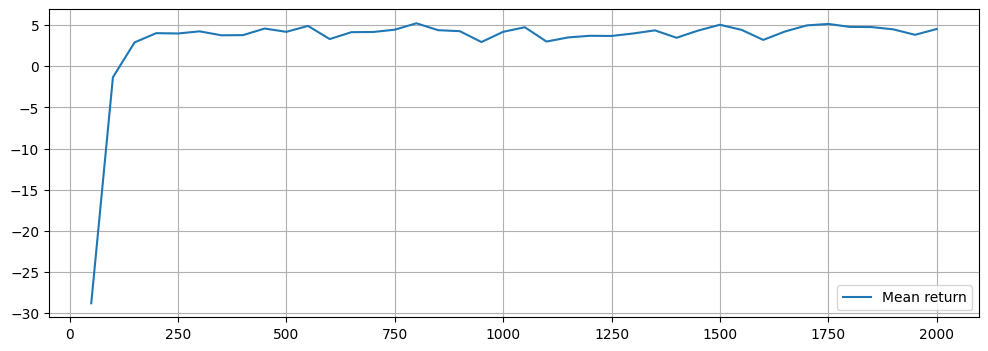

Episode: 2000, Return: -4, AvgReturn[50]: 5, Elapsed time: 0.04 seconds


In [61]:
# пример как считает DynaQ (тут формально обычно Q-обучение)

seed = 1337
agent = DynaQAgent(
    n_states=env.get_total_states(),
    n_actions=4,
    lr=0.05,
    gamma=0.975,
    eps=0.1,
    seed=seed,
    f_model=Model,
)

log_q, log_time = train(
    env=stoh_env,
    agent=agent,
    n_episodes=2001,
    on_model_updates=0,
    show_progress_schedule=50,
)

In [62]:
on_model_updates_dict = {i: dict() for i in range(11)}
for key in tqdm(on_model_updates_dict.keys()):
    seed = 1337
    agent = DynaQAgent(
        n_states=env.get_total_states(),
        n_actions=4,
        lr=0.05,
        gamma=0.975,
        eps=0.1,
        seed=seed,
        f_model=Model,
    )

    log_q, log_time = train(
        stoh_env,
        agent,
        n_episodes=2001,
        on_model_updates=key,
        show_progress_flag=False,
        show_progress_schedule=25,
    )
    on_model_updates_dict[key]["log_q"] = log_q
    on_model_updates_dict[key]["log_time"] = log_time

  0%|          | 0/11 [00:00<?, ?it/s]

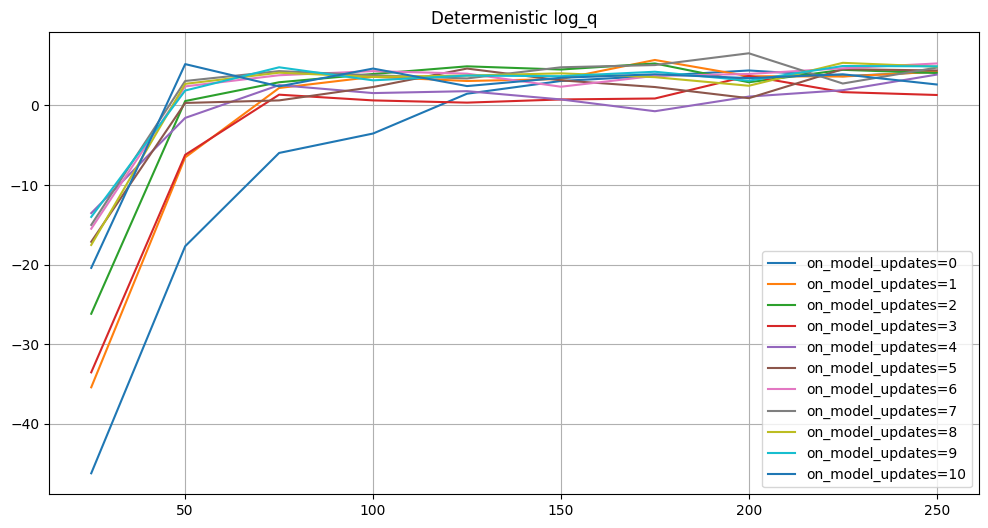

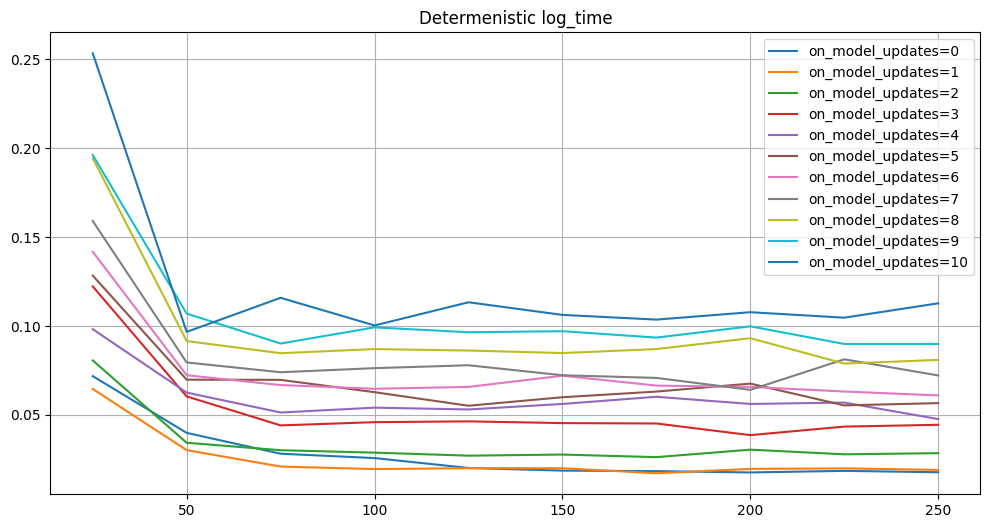

In [63]:
# графики для детерменированной среды

logs = []
for key in on_model_updates_dict.keys():
    logs.append(
        (on_model_updates_dict[key]["log_q"][:10], f"on_model_updates={key}")
    )  # ограничл число итераций тк после 250 впринципе достигнут оптимум


compare_logs(logs, title="Determenistic log_q")

logs = []
for key in on_model_updates_dict.keys():
    logs.append(
        (on_model_updates_dict[key]["log_time"][:10], f"on_model_updates={key}")
    )  # ограничл число итераций тк после 250 впринципе достигнут оптимум


compare_logs(logs, title="Determenistic log_time")

#### Выводы 

Наблюдается точно такая же картина по затратам времени, но более интересная картинка по зависивомсти вознаграждения от длинны мечтания. Наблюдается такой же тренд роста эффективности обучения с увеличением величины мечтания - однако к концу цепочки величины мечтания (особенно при величиен 6-7-8-9-10) наблюдается уменьшение припроста эффективности. Если 0 - 3 отличаются заметно на первых двух итерация, то на 6-7-8-9-10 как будто наблюдается минимальный прирост - что в свою очередь скорее всего объясняется стохастичной средой (условно за 10 мечтаний число случайностей нивелирует качество)